# Stroke Prediction

# 1. Prepare Problem

## a) Load libraries

In [46]:
import numpy as np
import pandas as pd
from sklearn.tree import plot_tree
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline

pd.set_option('display.width', 1000)
pd.set_option('precision', 3)

## b) Load dataset

In [2]:
filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")

# 2. Summarize Data

## a) Descriptive statistics

### View first rows

In [ ]:
data.head(10)

### View dimensions of data

In [ ]:
data.shape

### View data type for each attribute

In [ ]:
data.dtypes

### Mark features and target

In [16]:
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
target = 'stroke'

### Statistical Summary

In [ ]:
data.describe()

### Class Distribution

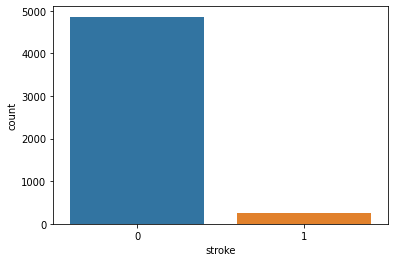

In [66]:
seaborn.countplot(x='stroke', data=data)
pyplot.show()


Our dataset is severely imbalanced.

### Identify Columns That Have Very Few Values

In [7]:
n_uniques = data.nunique()
print("Number of unique values in each columns")
print("{:<20}{:>8}{:>12}\t {}".format("Column", "n_unique", "Percentage", "Unique values"))
print("-----------------------------------------------------------------------------------------")
for col in data.columns:
    percentage = n_uniques[col] / data.shape[0] * 100
    print("{:<20}{:>8}{:>12.1f}%\t".format(col, n_uniques[col], percentage), (data[col].unique() if percentage < 1 else ""))

Number of unique values in each columns
Column              n_unique  Percentage	 Unique values
-----------------------------------------------------------------------------------------
gender                     2         0.0%	 ['Male' 'Female']
age                      104         2.0%	 
hypertension               2         0.0%	 [0 1]
heart_disease              2         0.0%	 [1 0]
ever_married               2         0.0%	 ['Yes' 'No']
work_type                  5         0.1%	 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type             2         0.0%	 ['Urban' 'Rural']
avg_glucose_level       3978        77.9%	 
bmi                      418         8.2%	 
smoking_status             4         0.1%	 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke                     2         0.0%	 [1 0]


Luckily, we don't have any single-value columns.

Downhere, we'll mark columns which have number of unique values less than 1% of total number of observations as categorical.

### Determine Numerical and Categorical Features

In [8]:
# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
for col in data.columns:
    if col != 'stroke':
        percentage = n_uniques[col]/data.shape[0] * 100
        if percentage < 1:
            categorical_ix.append(col)
        else:
            numerical_ix.append(col)
print("Categorical:", categorical_ix)
print("Numerical:", numerical_ix)

Categorical: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical: ['age', 'avg_glucose_level', 'bmi']


## b) Data visualizations

### Univariate Plots

The skew result show a positive (right) or negative (left) skew. Values closer to zero show
less skew.

#### Histograms

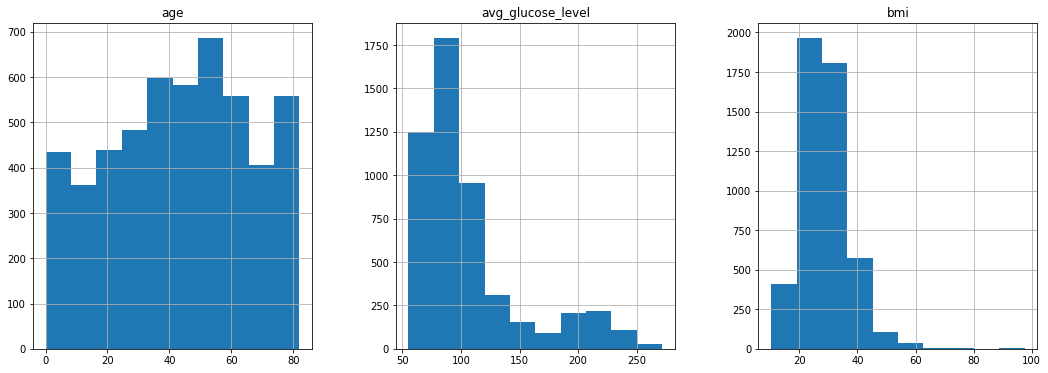

In [17]:
data[numerical_ix].hist(figsize=(18, 6), layout=(1, 3))
pyplot.show()

#### Density Plots

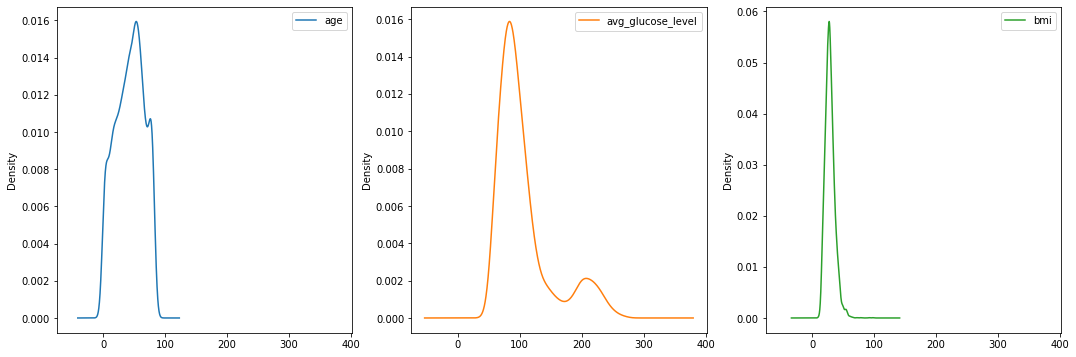

In [20]:
data[numerical_ix].plot(kind='density', subplots=True, layout=(1,3), figsize=(18, 6))
pyplot.show()

#### Skew of Univariate Distributions

In [25]:
data[numerical_ix].skew()

age                 -0.137
avg_glucose_level    1.572
bmi                  1.055
dtype: float64

#### Box and Whisker Plots

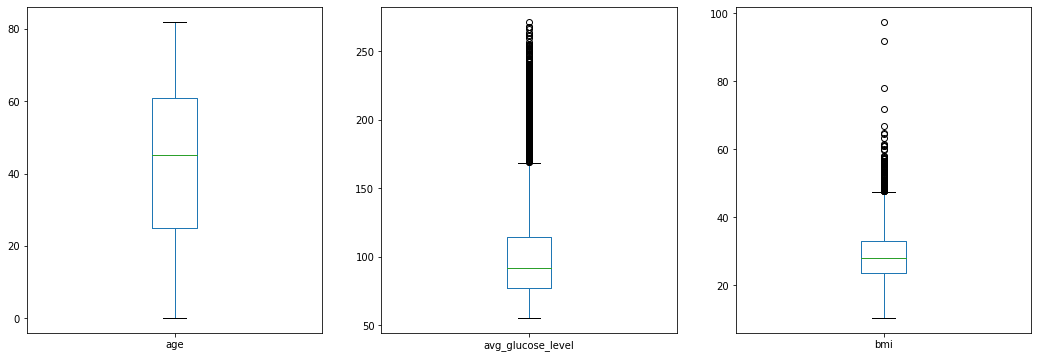

In [23]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.show()

#### Pie Plots

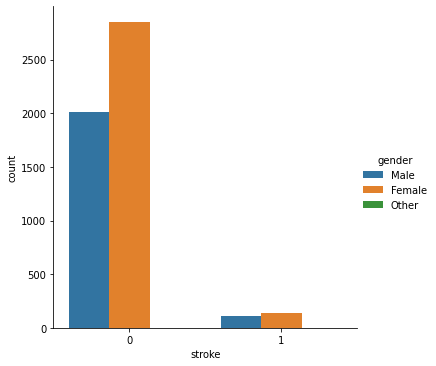

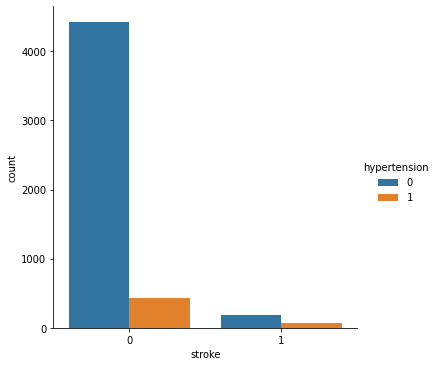

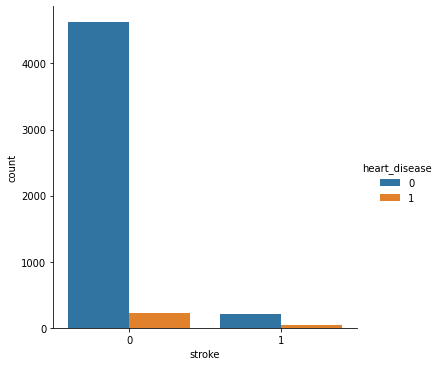

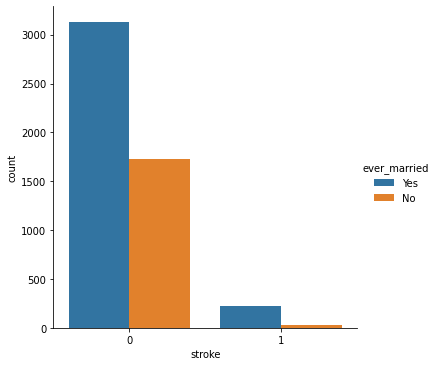

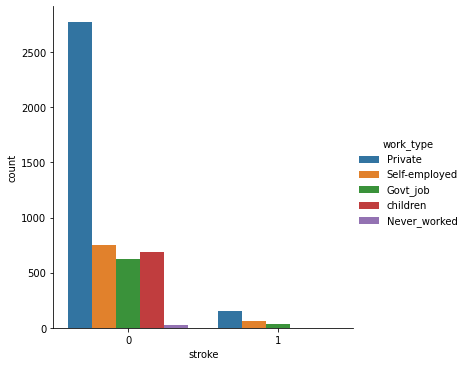

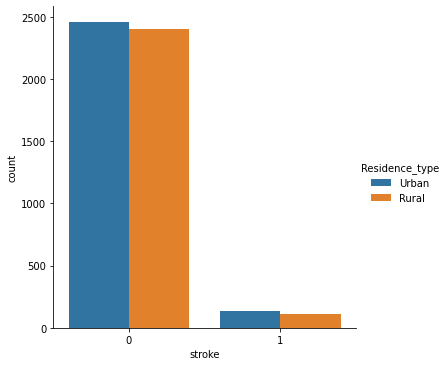

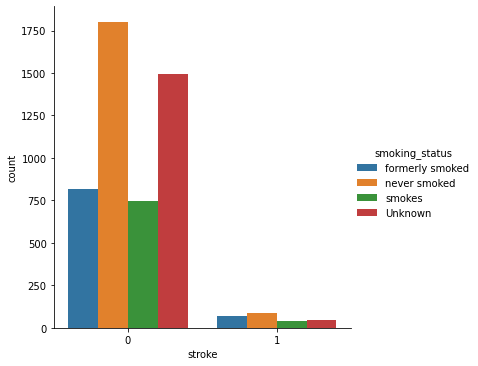

In [59]:
for col in categorical_ix:
    seaborn.catplot(x='stroke', kind='count', data=data, hue=col)

### Multivariate Plots

#### Correlation Matrix Plot

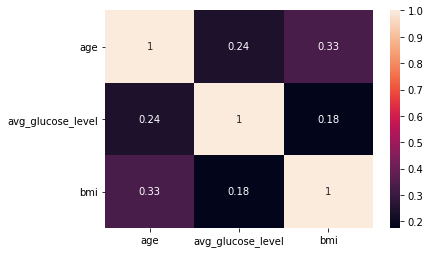

In [69]:
correlations = data[numerical_ix].corr(method='pearson')
seaborn.heatmap(correlations, annot=True)
pyplot.show()

#### Pair Plots

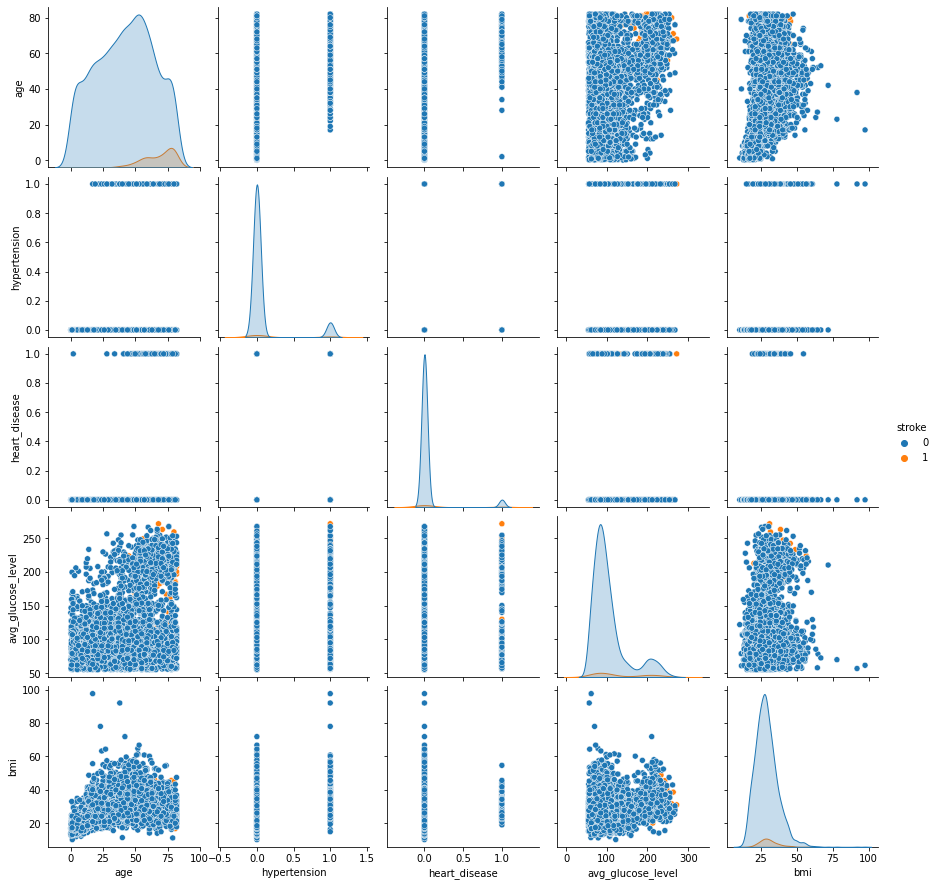

In [70]:
seaborn.pairplot(data, hue='stroke')
pyplot.show()

prompt a lot of questions, assumptions and hypotheses

# 3. Prepare Data

Start simple. Revisit this step often and cycle with the next step until you converge on a
subset of algorithms and a presentation of the data that results in accurate or accurate-enough
models to proceed.

## a) Data Cleaning

removing duplicates, marking missing values and even imputing missing
values.

### Remove Rows That Contain Duplicate Data

In [4]:
data = data[data['gender'] != "Other"]
before = data.shape[0]
dups = data.duplicated()
n_dups = len(data[dups])
data.drop_duplicates(inplace=True)
after = data.shape[0]
print("""\t\tNumber of rows
-------------------------------
Before\t\t%d
Duplicated\t%d
After\t\t%d
""" % (before, n_dups, after))

		Number of rows
-------------------------------
Before		5109
Duplicated	0
After		5109



### Outliers Removal On Numerical Features

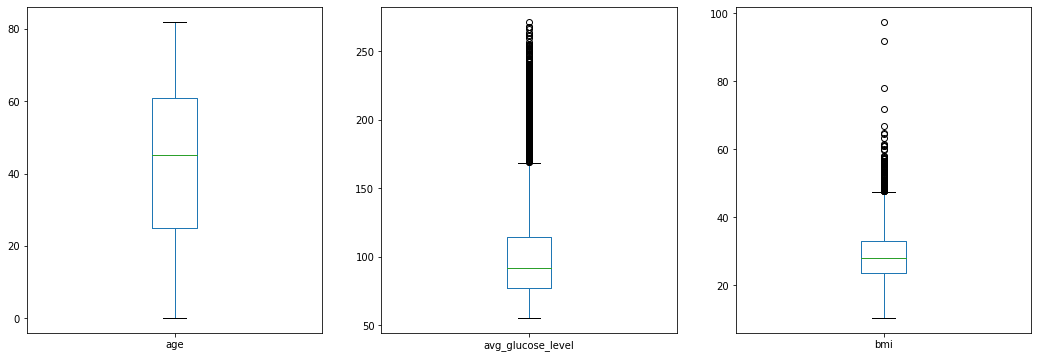

,age,avg_glucose_level,bmi
count,5109.000,5109.000,4908.000
mean,43.230,106.140,28.895
std,22.614,45.285,7.854
min,0.080,55.120,10.300
25%,25.000,77.240,23.500
50%,45.000,91.880,28.100
75%,61.000,114.090,33.100
max,82.000,271.740,97.600


In [9]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.show()

data[numerical_ix].describe()


By looking at the table, box plot and by research domain specific knowledge, we infer:

* *age* feature has outliers, where min value should be greater than or equal to 1
* *bmi* feature has outliers, where max value should not be far greater than 70


#### Option 1: Outlier Detection By Standard Deviation Method

From histogram, we assume *bmi* have near-Gaussian distribution. So we can apply Standard Deviation method in defining outliers.

Factor 4 of standard deviation from mean seems to be a reasonable boundary with *bmi* values.

In [ ]:
outlier_strategy = 'Standard_Deviation_Outlier_Detection'
bmi_mean, bmi_std = data["bmi"].mean(), data["bmi"].std()
factor = 4
cut_off = bmi_std * factor
bmi_upper = bmi_mean + cut_off
age_lower = 1

#### Option 2: Outlier Detection By Quantile Range

Factor 4 of IQR from quantile 75th seems to be a reasonable boundary with *bmi* values.

In [10]:
outlier_strategy = 'Quantile_Range_Outlier_Detection'
q25, q75 = data['bmi'].quantile(0.25), data['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off
age_lower = 1

#### Display Outliers

Quantile_Range_Outlier_Detection
UPPER BOUND FOR BMI IS NOW: 71.5
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 47


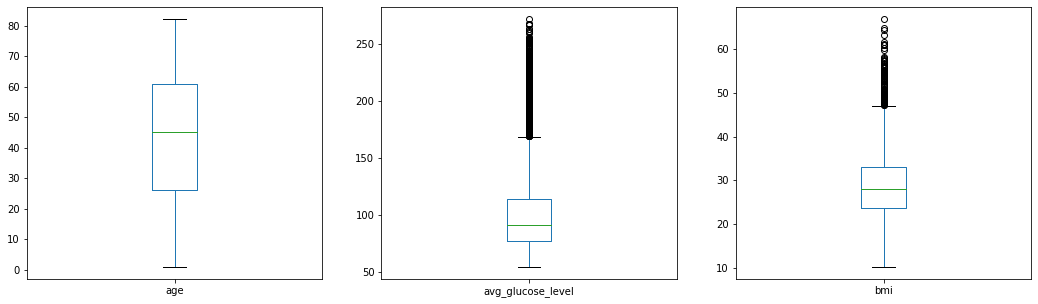

> THESE ARE OUTLIERS:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
7559,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
22706,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
545,Male,42.00,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
61511,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
41097,Female,23.00,1,0,No,Private,Urban,70.03,78.0,smokes,0
54747,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
53279,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
66772,Female,0.32,0,0,No,children,Rural,55.86,16.0,Unknown,0
68908,Female,0.72,0,0,No,children,Urban,66.36,23.0,Unknown,0


In [12]:
print(outlier_strategy)
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper)
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
mask_outlier = (data["bmi"] > bmi_upper) | (data["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

print("> NUMBER OF OUTLIERS DETECTED:", data[mask_outlier].shape[0])

# box and whisker plot
data[mask_nonoutlier][numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.show()

print("> THESE ARE OUTLIERS:")
data[mask_outlier]

#### Remove Detected Outliers On The Entire Data Set

In [13]:
data = data[mask_nonoutlier].copy()

### Impute Missing Values

In [ ]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        201            3.9%
> smoking_status               0            0.0%
> stroke                       0            0.0%


Looking at the above table and unique values of each column, we could tell *bmi* has 201 missing values.


Later on, we'll use `SimpleImputer` in Scikit-learn to replace missing values in *bmi* with its mean


## b) Data Transforms

### Distinguish Nominal And Ordinal Data

From the name and unique values of each categorical feature listed above, it's intuitive to label all of them as nominal, but we try treating them as ordinal for some kind of experiments later on.

### Select Strategy for Data Transformation

#### With Numerical Features

* Option 1: Rescale. This can be done by either normalization or standardization. Within scope of this course project, we'll be using `MinMaxScaler` from Scikit-learn to scale to range [0, 1].
* Option 2: Discretize. This can be done by using `KBinsDiscretizer` from Scikit-learn. We'll test its impact on Decision Tree performance.
> As far as we know, *age* and *bmi* can be separated into 4 groups each:
>* *age*:
>>* Under 14: Children
>>* 15-24: Youth
>>* 25-64: Adults
>>* 65 and over: Senior
>* *bmi*:
>>* Below 18.5: Underweight
>>* 18.5 – 24.9:	Norma
>>* 25.0 – 29.9:	Overweight
>>* 30.0 and Above: Obese
>
> In addition, blood sugar levels can also be split into 4 group, though normal sugar level depends on each specific age group:
>>* Fasting
>>* Before meal
>>* 1-2 hours after eating
>?* Bedtime

#### Encode Categorial Features

* Option 1: Convert to ordinal data
* Option 2: Convert to nominal data

#### Select And Run One Of The Options Below:

In [108]:
transformer = ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('MinMaxScaler', MinMaxScaler())]), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

In [190]:
transformer = ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

(3391, 10)

In [191]:
transformer = ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('MinMaxScaler', MinMaxScaler())]), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough')

(3391, 22)

In [ ]:
transformer = ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough')


# 4. Evaluate Algorithms

## a) Split-out Train Set And Test Set

In [28]:
# array = data[features].values
# X = array[:, :-1]
# Y = array[:, -1]
test_size = 0.5
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'])

## b) Test options and evaluation metric

We will use 10-fold cross validation to estimate accuracy. This will split our dataset into 10
parts, train on 9 and test on 1 and repeat for all combinations of train-test splits.

We'll not use `accuracy` as evaluation metric because it is only suitable when there are an equal number of observations in each class. However, that's not the case in our problem. Instead, we'll use F1 measure.

We expect recall is as high as possible, because we don't want to mis-label any stroke patients as not stroke when we do prediction.

In [18]:
num_folds = 10
scoring = 'f1'

## d) How SMOTE Affects CART Model's Performance

### SMOTE dataset
Let's see how SMOTE oversamples our dataset with ratio 0.4

		Without SMOTE


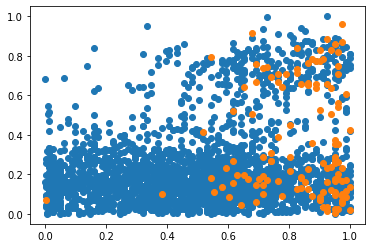

		SMOTE


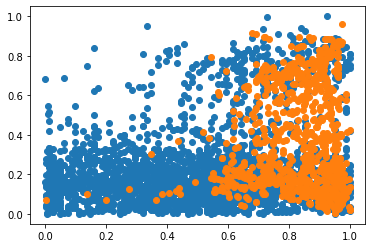

In [127]:
X_over, Y_over = transformer.fit_transform(X_train), Y_train
counter = Y_over.value_counts()
for label, _ in counter.items():
    row_ix = np.where(Y_over == label)[0]
    pyplot.scatter(X_over[row_ix, 0], X_over[row_ix, 1], label=str(label))
print('\t\tWithout SMOTE')
pyplot.show()

smote = Pipeline([('Trans', transformer),
                                        ('SMOTE', SMOTE(sampling_strategy=0.4))])
X_over, Y_over = smote.fit_resample(X_train, Y_train)
counter = Y_over.value_counts()
for label, _ in counter.items():
    row_ix = np.where(Y_over == label)[0]
    pyplot.scatter(X_over[row_ix, 0], X_over[row_ix, 1], label=str(label))
print('\t\tSMOTE')
pyplot.show()

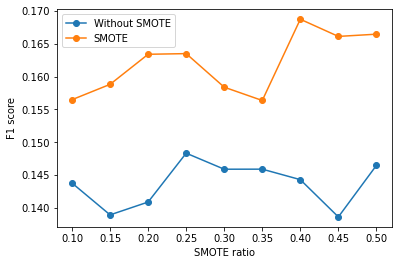

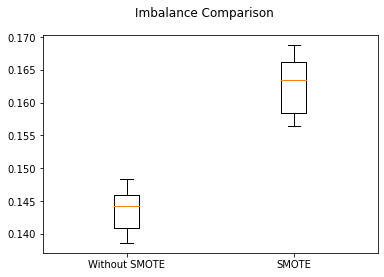

In [126]:
ratios = np.arange(0.1, 0.51, 0.05)
sum_imb_scores = [0] * len(ratios)
sum_smote_scores = [0] * len(ratios)
iter_nums = 5

for _ in range(iter_nums):
    for i in range(len(ratios)):
        imb_model = Pipeline([('Trans', transformer),
                              ('CART', DecisionTreeClassifier())])
        smote_model = Pipeline([('Trans', transformer),
                                     ('SMOTE', SMOTE(sampling_strategy=ratios[i])),
                                     ('CART', DecisionTreeClassifier())])

        kfold = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=5)
        imb_results = cross_val_score(imb_model, X_train, Y_train, cv=kfold, scoring=scoring)
        sum_imb_scores[i] += imb_results.mean()
        smote_results = cross_val_score(smote_model, X_train, Y_train, cv=kfold, scoring=scoring)
        sum_smote_scores[i] += smote_results.mean()

avg_imb_scores = [i/iter_nums for i in sum_imb_scores]
avg_smote_scores = [i/iter_nums for i in sum_smote_scores]

# Line plots
line1 = pyplot.plot(ratios, avg_imb_scores, '-o', label='Without SMOTE')
line2 = pyplot.plot(ratios, avg_smote_scores, '-o', label='SMOTE')
pyplot.legend()
pyplot.ylabel('F1 score')
pyplot.xlabel('SMOTE ratio')
pyplot.show()

# Box plots
fig = pyplot.figure()
fig.suptitle('Imbalance Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot([avg_imb_scores, avg_smote_scores])
ax.set_xticklabels(['Without SMOTE', 'SMOTE'])
pyplot.show()

SMOTE helps increase the performance of Decision Tree. We'll choose 0.4 as the SMOTE ratio for the rest of our Decision Tree Tuning.

# 5. Improve Accuracy

## a) Algorithm Tuning

### Decision Tree Tuning

scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.

```
DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
```

In [7]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledValidationX = scaler.transform(X_validation)

#### `splitter`

According to some articles, decision trees tend to overfit on data with large number of features.

Besides, it can do feature selection automatically by applying (Im)purity measure. This can be done by set parameter `splitter=best`. Another value for `splitter` is `random`. If we have hundreds of features, `best` is more preferred because `random` might result in features that don’t give much information, which would lead to a more deeper, less precise tree.

However, with our Stroke data is small with 10 features, so we might be able to see the difference.

splitter: best => Accuracy score: 0.952(Train), 0.950(Validation)
splitter: random => Accuracy score: 0.952(Train), 0.950(Validation)


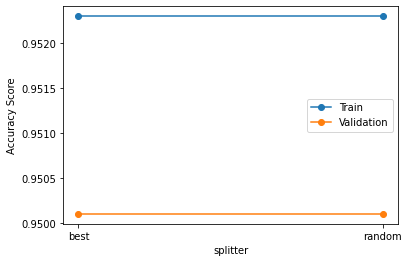

In [ ]:
train_results = []
validation_results = []

splitters = ['best', 'random']

for splitter in splitters:
    model = DecisionTreeClassifier(splitter=splitter)
    model.fit(rescaledX, Y_train)

    train_result = accuracy_score(Y_train, model.predict(rescaledX))
    train_results.append(train_result)

    validation_result = accuracy_score(Y_validation, model.predict(rescaledValidationX))
    validation_results.append(validation_result)

    print("splitter: %s => Accuracy score: %.3f(Train), %.3f(Validation)" % (splitter, train_result, validation_result))

line1 = pyplot.plot(splitters, train_results, '-o', label='Train')
line2 = pyplot.plot(splitters, validation_results, '-o', label='Validation')

pyplot.legend()

pyplot.ylabel('Accuracy Score')
pyplot.xlabel('splitter')
pyplot.show()

#### `max_depth`

This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data

max_depths: 1 => Accuracy score: 0.951(Train), 0.951(Validation)
max_depths: 2 => Accuracy score: 0.951(Train), 0.951(Validation)
max_depths: 3 => Accuracy score: 0.951(Train), 0.951(Validation)
max_depths: 4 => Accuracy score: 0.951(Train), 0.951(Validation)
max_depths: 5 => Accuracy score: 0.952(Train), 0.946(Validation)
max_depths: 6 => Accuracy score: 0.952(Train), 0.951(Validation)
max_depths: 7 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 8 => Accuracy score: 0.952(Train), 0.948(Validation)
max_depths: 9 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 10 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 11 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 12 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 13 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 14 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 15 => Accuracy score: 0.952(Train), 0.950(Validation)
max_depths: 16 => A

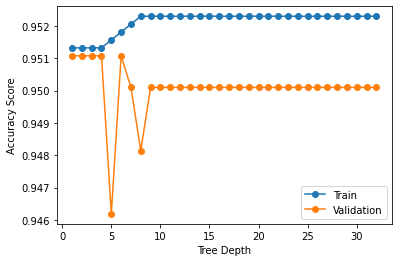

In [ ]:
train_results = []
validation_results = []

max_depths = np.arange(1, 33, 1)

for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(rescaledX, Y_train)

    train_result = accuracy_score(Y_train, model.predict(rescaledX))
    train_results.append(train_result)

    validation_result = accuracy_score(Y_validation, model.predict(rescaledValidationX))
    validation_results.append(validation_result)

    print("max_depths: %d => Accuracy score: %.3f(Train), %.3f(Validation)" % (max_depth, train_result, validation_result))

line1 = pyplot.plot(max_depths, train_results, '-o', label='Train')
line2 = pyplot.plot(max_depths, validation_results, '-o', label='Validation')

pyplot.legend()

pyplot.ylabel('Accuracy Score')
pyplot.xlabel('max_depth')
pyplot.show()

#### `min_samples_split`

The minimum number of samples required to split an internal node.

min_samples_split: 2 => Accuracy score: 0.952(Train), 0.950(Validation)
min_samples_split: 3 => Accuracy score: 0.952(Train), 0.950(Validation)
min_samples_split: 4 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_split: 5 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_split: 6 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_split: 7 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_split: 8 => Accuracy score: 0.952(Train), 0.951(Validation)
min_samples_split: 9 => Accuracy score: 0.952(Train), 0.951(Validation)
min_samples_split: 10 => Accuracy score: 0.952(Train), 0.951(Validation)
min_samples_split: 11 => Accuracy score: 0.952(Train), 0.951(Validation)
min_samples_split: 12 => Accuracy score: 0.952(Train), 0.951(Validation)
min_samples_split: 13 => Accuracy score: 0.952(Train), 0.951(Validation)
min_samples_split: 14 => Accuracy score: 0.952(Train), 0.946(Validation)
min_samples_split: 15 => Accuracy score: 0.952(Train), 0.94

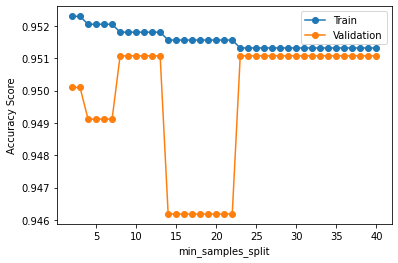

In [ ]:
train_results = []
validation_results = []

min_samples_splits = np.arange(2, 41, 1)

for min_samples_split in min_samples_splits:
    model = DecisionTreeClassifier(min_samples_split=min_samples_split)
    model.fit(rescaledX, Y_train)

    train_result = accuracy_score(Y_train, model.predict(rescaledX))
    train_results.append(train_result)

    validation_result = accuracy_score(Y_validation, model.predict(rescaledValidationX))
    validation_results.append(validation_result)

    print("min_samples_split: %d => Accuracy score: %.3f(Train), %.3f(Validation)" % (min_samples_split, train_result, validation_result))

line1 = pyplot.plot(min_samples_splits, train_results, '-o', label='Train')
line2 = pyplot.plot(min_samples_splits, validation_results, '-o', label='Validation')

pyplot.legend()

pyplot.ylabel('Accuracy Score')
pyplot.xlabel('min_samples_split')
pyplot.show()



#### `min_samples_leaf`

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least a number of training samples in each of the left and right branches

min_samples_leaf: 1 => Accuracy score: 0.952(Train), 0.950(Validation)
min_samples_leaf: 2 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_leaf: 3 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_leaf: 4 => Accuracy score: 0.952(Train), 0.951(Validation)
min_samples_leaf: 5 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_leaf: 6 => Accuracy score: 0.952(Train), 0.949(Validation)
min_samples_leaf: 7 => Accuracy score: 0.952(Train), 0.946(Validation)
min_samples_leaf: 8 => Accuracy score: 0.952(Train), 0.946(Validation)
min_samples_leaf: 9 => Accuracy score: 0.952(Train), 0.946(Validation)
min_samples_leaf: 10 => Accuracy score: 0.951(Train), 0.951(Validation)
min_samples_leaf: 11 => Accuracy score: 0.951(Train), 0.951(Validation)
min_samples_leaf: 12 => Accuracy score: 0.951(Train), 0.951(Validation)
min_samples_leaf: 13 => Accuracy score: 0.951(Train), 0.951(Validation)
min_samples_leaf: 14 => Accuracy score: 0.951(Train), 0.951(Validation)
m

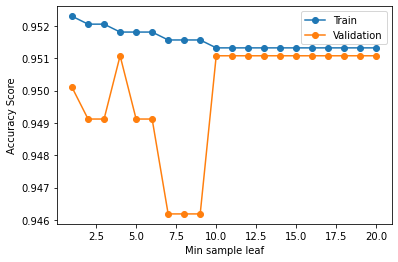

In [ ]:
train_results = []
validation_results = []

min_samples_leafs = np.arange(1, 21, 1)

for min_samples_leaf in min_samples_leafs:
    model = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(rescaledX, Y_train)

    train_result = accuracy_score(Y_train, model.predict(rescaledX))
    train_results.append(train_result)

    validation_result = accuracy_score(Y_validation, model.predict(rescaledValidationX))
    validation_results.append(validation_result)

    print("min_samples_leaf: %d => Accuracy score: %.3f(Train), %.3f(Validation)" % (min_samples_leaf, train_result, validation_result))

line1 = pyplot.plot(min_samples_leafs, train_results, '-o', label='Train')
line2 = pyplot.plot(min_samples_leafs, validation_results, '-o', label='Validation')

pyplot.legend()

pyplot.ylabel('Accuracy Score')
pyplot.xlabel('min_samples_leaf')
pyplot.show()

#### `max_features`

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least a number of training samples in each of the left and right branches

max_features: 1 => Accuracy score: 0.952(Train), 0.950(Validation)
max_features: 2 => Accuracy score: 0.952(Train), 0.950(Validation)
max_features: 3 => Accuracy score: 0.952(Train), 0.950(Validation)


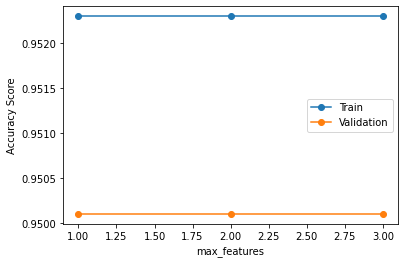

In [ ]:
train_results = []
validation_results = []

max_featuress = np.arange(1, 4, 1)

for max_features in max_featuress:
    model = DecisionTreeClassifier(max_features=max_features)
    model.fit(rescaledX, Y_train)

    train_result = accuracy_score(Y_train, model.predict(rescaledX))
    train_results.append(train_result)

    validation_result = accuracy_score(Y_validation, model.predict(rescaledValidationX))
    validation_results.append(validation_result)

    print("max_features: %d => Accuracy score: %.3f(Train), %.3f(Validation)" % (max_features, train_result, validation_result))

line1 = pyplot.plot(max_featuress, train_results, '-o', label='Train')
line2 = pyplot.plot(max_featuress, validation_results, '-o', label='Validation')

pyplot.legend()

pyplot.ylabel('Accuracy Score')
pyplot.xlabel('max_features')
pyplot.show()

# CHANGE NUMBER OF RANGE(...) AFTER PREPROCESSING

#### `class_weight`

Weights associated with classes.

class_weight: None => Accuracy score: 0.952(Train), 0.950(Validation)
class_weight: balanced => Accuracy score: 0.747(Train), 0.710(Validation)


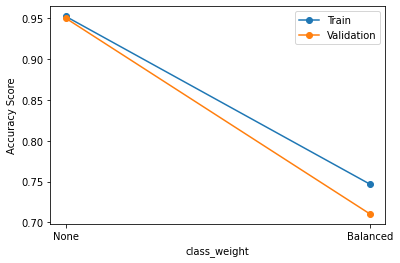

In [ ]:
train_results = []
validation_results = []

class_weights = [None, 'balanced']

for class_weight in class_weights:
    model = DecisionTreeClassifier(class_weight=class_weight)
    model.fit(rescaledX, Y_train)

    train_result = accuracy_score(Y_train, model.predict(rescaledX))
    train_results.append(train_result)

    validation_result = accuracy_score(Y_validation, model.predict(rescaledValidationX))
    validation_results.append(validation_result)

    print("class_weight: %s => Accuracy score: %.3f(Train), %.3f(Validation)" % (class_weight, train_result, validation_result))

class_weights = ['None', 'Balanced']
line1 = pyplot.plot(class_weights, train_results, '-o', label='Train')
line2 = pyplot.plot(class_weights, validation_results, '-o', label='Validation')

pyplot.legend()

pyplot.ylabel('Accuracy Score')
pyplot.xlabel('class_weight')
pyplot.show()

#### Try multiple parameters at once

In [8]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

splitters = ['best', 'random']
max_depths = np.arange(1, 13, 1)
min_samples_splits = np.arange(2, 25, 1)
min_samples_leafs = np.arange(1, 13, 1)
max_featuress = np.arange(1, 4, 1)
class_weights = [None, 'balanced']

param_grid = dict(splitter=splitters, max_depth=max_depths, min_samples_split=min_samples_splits, min_samples_leaf=min_samples_leafs, max_features=max_featuress, class_weight=class_weights)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with %r" % (mean, stdev, param))

# CHANGE VALUES RANGE AFTER COMPLETING PREPARATION


Streaming output truncated to the last 5000 lines.
0.731172 (0.026612) with {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 9, 'splitter': 'best'}
0.701813 (0.035108) with {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 9, 'splitter': 'random'}
0.731172 (0.026612) with {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 10, 'splitter': 'best'}
0.722854 (0.026152) with {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 10, 'splitter': 'random'}
0.731172 (0.026612) with {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 11, 'splitter': 'best'}
0.719920 (0.028505) with {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 11, 'splitter': 'random

In [9]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.951810 using {'class_weight': None, 'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 8, 'splitter': 'best'}


## b) Ensembles

research ensemble methods such as Random Forest

# 6. Finalize Model

## a) Predictions on validation dataset

The CART algorithm was the most accurate model that we tested. Now we want to get an idea
of the accuracy of the model on our validation dataset. This will give us an independent final
check on the accuracy of the best model.

In [ ]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
cart = DecisionTreeClassifier(criterion='gini', splitter='best')
cart.fit(rescaledX, Y_train)

# estimate on the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = cart.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))


0.9500978473581213
[[970   2]
 [ 49   1]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       972
         1.0       0.33      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022



## b) Create standalone model on entire training dataset

## c) Save model for later use




# Reading:
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontree#sklearn.tree.DecisionTreeClassifier

Other's solutions:

https://www.kaggle.com/arthurtelders/zillow-ml-lasso